# [CS 6476 Project 2: Local Feature Matching](https://www.cc.gatech.edu/~hays/compvision/proj2/)

This iPython notebook:  
(1) Loads and resizes images  
(2) Finds interest points in those images                 (you code this)  
(3) Describes each interest point with a local feature    (you code this)  
(4) Finds matching features                               (you code this)  
(5) Visualizes the matches  
(6) Evaluates the matches based on ground truth correspondences  

## Setup

In [1]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from student_feature_matching import match_features
from student_sift import get_features
from student_harris import get_interest_points
from IPython.core.debugger import set_trace

# Notre Dame 
image1 = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg')
image2 = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg')
eval_file = '../data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'

# # Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
#image1 = load_image('../data/Mount Rushmore/9021235130_7c2acd9554_o.jpg')
#image2 = load_image('../data/Mount Rushmore/9318872612_a255c874fb_o.jpg')
#eval_file = '../data/Mount Rushmore/9021235130_7c2acd9554_o_to_9318872612_a255c874fb_o.pkl'

# # Episcopal Gaudi -- This pair is relatively difficult
#image1 = load_image('../data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg')
#image2 = load_image('../data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg')
#eval_file = '../data/Episcopal Gaudi/4386465943_8cf9776378_o_to_3743214471_1b5bbfda98_o.pkl'
                    
scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

feature_width = 16 # width and height of each local feature, in pixels. 

## Find distinctive points in each image (Szeliski 4.1.1)

In [2]:
import numpy as np
import math


def match_features(f1, f2, x1, y1, x2, y2):
        
    Val = list()
    hx = list()
    hy = list()
    
    a = f1.shape[0]
    b = f2.shape[0]
    Distance = np.ones((a, b))

    
    for i in range(a):

        for j in range(b):

            fimg1 = f1[[i],:]
            fimg2 = f2[[j],:]


            dif = pow ((fimg1 - fimg2), 2)

            add = dif.sum()

            add = pow(add, 0.5)

            Distance[i,j] = add


        position = np.argsort(Distance[i,:],kind = 'heapsort',  axis = -1)
       
        vec1 = position[0]
        vec2 = position[1]
        pos1 = Distance[i,vec1]
        pos2 = Distance[i,vec2]
        edge = pos1/pos2

        if edge <0.80 :

            hx.append(i)

            hy.append(vec1)

            Val.append(pos1)

    confidences = np.asanyarray(Val)
    
    pos_X = np.asanyarray(hx)
    pos_Y = np.asanyarray(hy)
    similarities = np.stack((pos_X, pos_Y), axis = -1)
    



    return similarities, confidences
    

In [3]:
import cv2
import numpy as np
import math

def ANMS (x , y, r, maximum):

    index = 0
    count = 0
    mylist = list()

    while index < len(x):

        num = 20000000000

        x1_Coordinate = x[index]
      
        y1_Coordinate = y[index]

        

        while count < len(x):
            
            x2_Coordinate = x[count]
            y2_Coordinate = y[count]
            
            x_dif = x2_Coordinate - x1_Coordinate
            y_dif = y2_Coordinate - y1_Coordinate

            if (x1_Coordinate != x2_Coordinate and y1_Coordinate != y2_Coordinate) and r[index] < r[count]:

                distance =((x_dif)*(x_dif) + (y_dif)*(y_dif))**0.5

                if distance < num:

                    num = distance

            count += 1 

        mylist.append([x1_Coordinate, y1_Coordinate, num])
        
        index += 1
        count = 0

    mylist.sort(key = lambda t: t[2])
    mylist = mylist[len(mylist)-maximum:len(mylist)]

    return mylist




def get_interest_points(image, feature_width):

    img_width = image.shape[0]
    img_height = image.shape[1]
       
    xedge = list()
    yedge = list()
    val = list()

    border = cv2.borderInterpolate(0, 1, cv2.BORDER_CONSTANT)
    x_factor = cv2.Sobel(image, cv2.CV_64F,1,0,ksize = 5, borderType = border)
    y_factor = cv2.Sobel(image, cv2.CV_64F,0,1,ksize = 5, borderType = border)

    Mx  = pow(x_factor,2)
    My  = pow(y_factor,2)
    Mxy = x_factor * y_factor

    for m in range(16, img_width - 16):
        
        for n in range(16, img_height - 16):

            Ixx = Mx[m-1:m+1 , n-1:n+1]
            Iyy = My[m-1:m+1 , n-1:n+1]
            Ixy = Mxy[m-1:m+1, n-1:n+1]

            sumx = Ixx.sum()
            sumy = Iyy.sum()
            sumxy = Ixy.sum()

            Det = sumx*sumy - sumxy*sumxy
            addxy = pow((sumx + sumy),2)
            sec = addxy * 0.04
            res = Det - sec

            if res > 9999:

                xedge.append(n)
                yedge.append(m)
                val.append(res)


    xedge = np.asarray(xedge)
    yedge = np.asarray(yedge)
    val = np.asarray(val)

    angle = ANMS(xedge, yedge, val, 3025)

    angle = np.asarray(angle)

    x = angle[:,0]
    y = angle[:,1]
    scales = angle[:,2]


    return x, y, scales

In [4]:
import numpy as np
import cv2
import math


def get_features(image, x, y, feature_width):

  x =  (np.trunc(x)).astype(np.int32)
  y =  (np.trunc(y)).astype(np.int32)
  xdir = len (x)
  ydir = len (y)

  Filter = cv2.getGaussianKernel(4, 10)
  Filter = np.dot(Filter, Filter.T)

  image = cv2.filter2D(image, -1, Filter)

  Normalise = np.ones((xdir,128))


  for i1 in range(xdir):

    xpattern = int(x[i1])
    ypattern = int(y[i1])
    
    box = image[ypattern-8:ypattern + 8, xpattern-8:xpattern + 8] 

    for i2 in range(4): 
      for i3 in range(4):

        frame = box[i2*4:i2*4 +4,i3*4: i3*4+4]
        cut = cv2.copyMakeBorder(frame, 1, 1, 1, 1, cv2.BORDER_REFLECT)
        shape = np.ones((4,4))
        attitude = np.ones((4,4))
        
        S1 = frame.shape[0]
        S2 = frame.shape[1]

        for i4 in range(S1):
          for i5 in range(S2):

            shape[i4,i5] = math.sqrt((cut[i4+1,i5] - cut[i4-1,i5])**2 + (cut[i4,i5+1] - cut[i4,i5-1])**2)
            attitude[i4,i5] = np.arctan2((cut[i4+1,i5] - cut[i4-1,i5]),(cut[i4,i5+1] - cut[i4,i5-1]))

        shape = shape
        condition = attitude * 30
        fig, border = np.histogram(condition, bins = 8, range = (-180, 180), weights = shape, density = False)
        
        for i6 in range(8):
          n = i6 + i3*8 + i2*32 
          Normalise[i1,n] = fig[i6]


  R1 = Normalise.shape[0]
  R2 = Normalise.shape[1]
  
  for i7 in range(R1):
    plus = 0
    
    for i8 in range(R2): 
      plus = plus + pow((Normalise[i7][i8]),2)
    plus = math.sqrt(plus)

    for i9 in range(R2):
      Normalise[i7][i9] = Normalise[i7][i9]/plus

  finalise = Normalise

  return finalise

3025 corners in image 1, 3025 corners in image 2


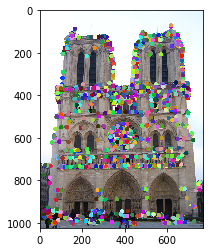

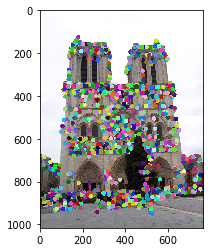

In [5]:
x1, y1, scales1= get_interest_points(image1_bw, feature_width)

x2, y2, scales2 = get_interest_points(image2_bw, feature_width)

#x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
#plt.figure(); plt.imshow(image1_bw)

# Visualize the interest points
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

## Create feature vectors at each interest point (Szeliski 4.1.2)

In [6]:
#scale 1$2 removed
image1_features = get_features(image1_bw, x1, y1, feature_width)
image2_features = get_features(image2_bw, x2, y2, feature_width)

## Match features (Szeliski 4.1.3)

In [7]:
matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

171 matches from 3025 corners


## Visualization

You might want to set 'num_pts_to_visualize' and 'num_pts_to_evaluate' to some constant (e.g. 100) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. You can comment out one of both of them if you prefer.

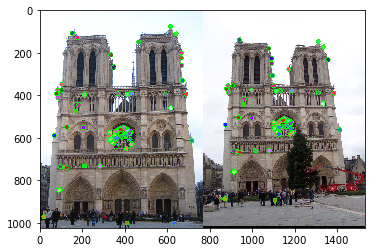

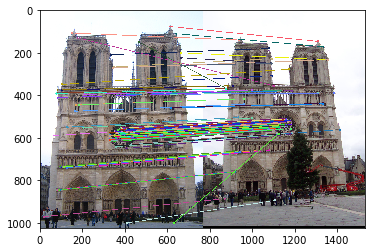

In [8]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles.jpg', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines.jpg', dpi=1000)

Comment out the function below if you are not testing on the Notre Dame, Episcopal Gaudi, and Mount Rushmore image pairs--this evaluation function will only work for those which have ground truth available.  
  
You can use `annotate_correspondences/collect_ground_truth_corr.py` to build the ground truth for other image pairs if you want, but it's very tedious. It would be a great service to the class for future years, though!

Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Correct
Incorrect
Incorrect
Correct
Correct
Correct
Incorrect
Correct
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Incorrect
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
You found 100/100 required matches
Accuracy = 0.860000


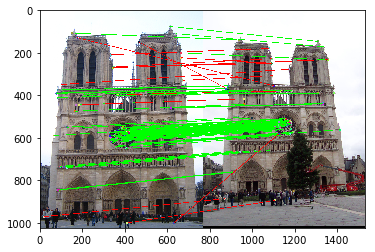

In [9]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval.jpg', dpi=1000)